In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 
from scipy import optimize

import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to get the price data from yahoo finance 
def getDataBatch(tickers, startdate, enddate):
  def getData(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map(getData, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date'],sort=False))

download_flag = False
if download_flag:
    start_dt = datetime.datetime(2008, 10, 31)
    end_dt = datetime.datetime(2018, 10, 31)
    tickers = ['ACAD','ALKS','ALNY','ALXN','AMGN','ARRY','BIIB','BMRN','CELG','EXEL','FOLD','GHDX','GILD','HALO','ILMN','IMMU','INCY','IONS','JAZZ','LGND','MDCO','MYGN','MYL','NBIX','NKTR','OPK','REGN','RGEN','SGEN','SHPG','SRPT','TECH','UTHR','VRTX']
    stock_data = getDataBatch(tickers, start_dt, end_dt)
    daily_close_px = stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
    # write excel
    daily_close_px.to_csv('TEdata.csv', header=True, index=True)
else:
    daily_close_px = pd.read_csv('TEdata.csv', index_col='Date')

# weights
TickerNWeights = pd.read_excel('weight.xlsx', sheet_name='Sheet1', header=0, index_col=0)
wts_index = TickerNWeights['Weight']


In [3]:
# sort tickers by weights
daily_close_px_transpose = daily_close_px.T
daily_close_px_transpose.loc[:,'Weight'] = TickerNWeights.loc[:,'Weight']
daily_close_px_sort = daily_close_px_transpose.sort_values('Weight',ascending=False,axis=0)
del daily_close_px_sort['Weight']

daily_close_px2 = daily_close_px_sort.T
TickerNWeights2 = TickerNWeights.loc[:,"Weight"].sort_values(ascending = False)

# Calculate returns
daily_return = daily_close_px2.pct_change().dropna()
num_periods, num_stock = daily_return.shape

In [4]:
Index_prs = pd.DataFrame(daily_close_px2 @ TickerNWeights2)

Index_ret = pd.DataFrame(daily_return @ TickerNWeights2)
Index_risk = pd.DataFrame(Index_ret ** 2)

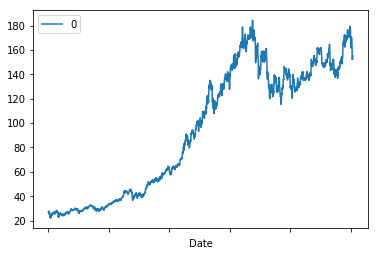

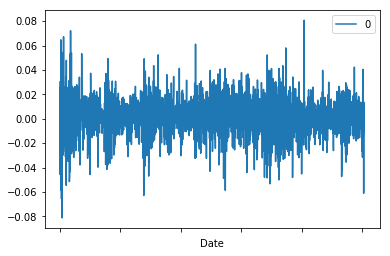

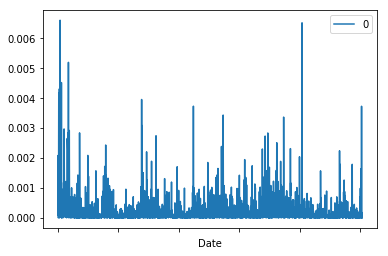

In [5]:
Index_prs.plot()
Index_ret.plot()
Index_risk.plot()

In [6]:
# define optimizer function step by step
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def te_opt(W_Bench, C, obj_te, c_, b_):
    # function that minimize the objective function
    n = len(W_Bench)
    # change the initial guess to help test whether we find the global optimal
    guess = 2
    #W = rand_weights(n) # start with random weights
    if guess==1:
        W = rand_weights(n) # start with random weights
    elif guess==2:
        W = W_Bench # Use Bench weight as initial guess
    else:
        W = 1/n*np.ones([n,1])
    
    optimized = optimize.minimize(obj_te, W, (W_Bench, C), 
                method='SLSQP', constraints=c_, bounds=b_,  
                options={'ftol':1e-10, 'maxiter': 1000000, 'disp': False})        
    if not optimized.success: 
        raise BaseException(optimized.message)
    return optimized.x  # Return optimized weights

def obj_te(W, W_Bench, C): 
    wts_active = W - W_Bench
    return(np.sqrt(np.transpose(wts_active)@C@wts_active))

def opt_min_te(W, C, b_, c_):
    return(te_opt(W, C, obj_te, c_, b_))
    
# define EWMA covariance
def ewma_cov(rets, lam): 
    T, n = rets.shape
    ret_mat = rets.as_matrix()
    EWMA = np.zeros((T,n,n))
    S = np.cov(ret_mat.T)  
    EWMA[0,:] = S
    for i in range(1, T) :
        S = lam * S  + (1-lam) * np.matmul(ret_mat[i-1,:].reshape((-1,1)), 
                      ret_mat[i-1,:].reshape((1,-1)))
        EWMA[i,:] = S

    return(EWMA)

In [7]:
def tracking_error(wts_active,cov):
    TE = np.sqrt(np.transpose(wts_active) @ cov @ wts_active)
    return TE

lamda = 0.94
# vol of the assets 
vols = daily_return.std()
rets_mean = daily_return.mean()
# demean the returns
daily_return = daily_return - rets_mean

# var_ewma calculation of the covraiance using the function from module risk_opt.py
var_ewma = ewma_cov(daily_return, lamda)
# take only the covariance matrix for the last date, which is the forecast for next time period
cov_end = var_ewma[-1,:]

cov_end_annual = cov_end*252 #Annualize
std_end_annual = np.sqrt(np.diag(cov_end))*np.sqrt(252)
# calculate the correlation matrix
corr = daily_return.corr()

In [9]:
# looping through number of stocks and save the history of TEs
num_stock_b = 10
num_stock_e = 21
numstock_2use = range(num_stock_b,num_stock_e)
wts_active_hist = np.zeros([len(numstock_2use), num_stock])
TE_hist = np.zeros([len(numstock_2use), 1])
count = 0

for i in numstock_2use:
    # only the top weight stocks + no shorting 
    b1_c_a_ = [(0.0,1.0) for j in range(i)] 
    # exclude bottom weighted stocks
    b1_c_b_ = [(0.0,0.0) for j in range(i,num_stock)] 
    b1_curr_ = b1_c_a_ + b1_c_b_
    c1_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
    wts_min_curr = opt_min_te(TickerNWeights2, cov_end_annual, b1_curr_, c1_)
    wts_active_hist[count,:] = wts_min_curr.transpose()
    TE_optimized_c = tracking_error(wts_min_curr-TickerNWeights2,cov_end)
    TE_hist[count,:] = TE_optimized_c*10000# in bps
    count = count+1
    
    del b1_curr_, b1_c_a_, b1_c_b_,TE_optimized_c,wts_min_curr

In [10]:
TE_hist

array([[19.22873836],
       [18.20319096],
       [18.18465049],
       [12.9547821 ],
       [12.68261318],
       [10.97929982],
       [ 9.11154313],
       [ 5.7733172 ],
       [ 5.60835329],
       [ 4.86134604],
       [ 4.37845029]])

In [11]:
ans = TE_hist.squeeze()[-1]
print('20 top weighted stock replication TE = %.2f bps.'%ans)

20 top weighted stock replication TE = 4.38 bps.


<Figure size 432x288 with 0 Axes>

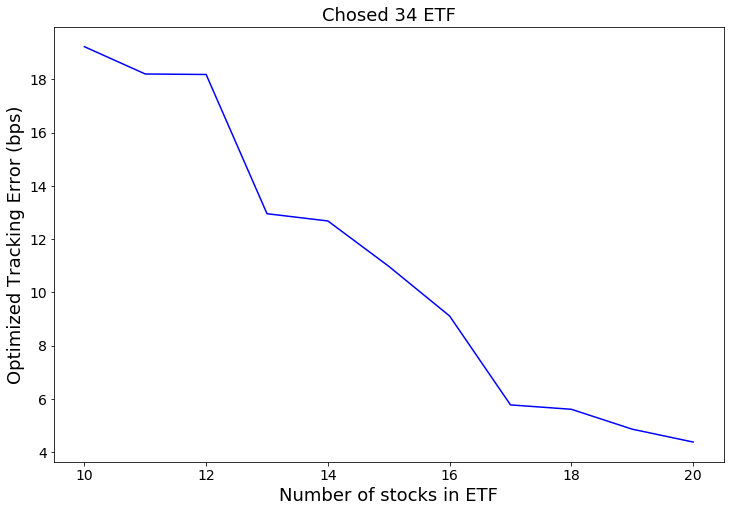

In [13]:
#------plot TE as a function of number of stocks -------------
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(range(num_stock_b,num_stock_e), TE_hist, 'b')
plt.xlabel('Number of stocks in ETF', fontsize=18)
plt.ylabel('Optimized Tracking Error (bps)', fontsize=18)
plt.title('Chosed 34 ETF', fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

<Figure size 432x288 with 0 Axes>

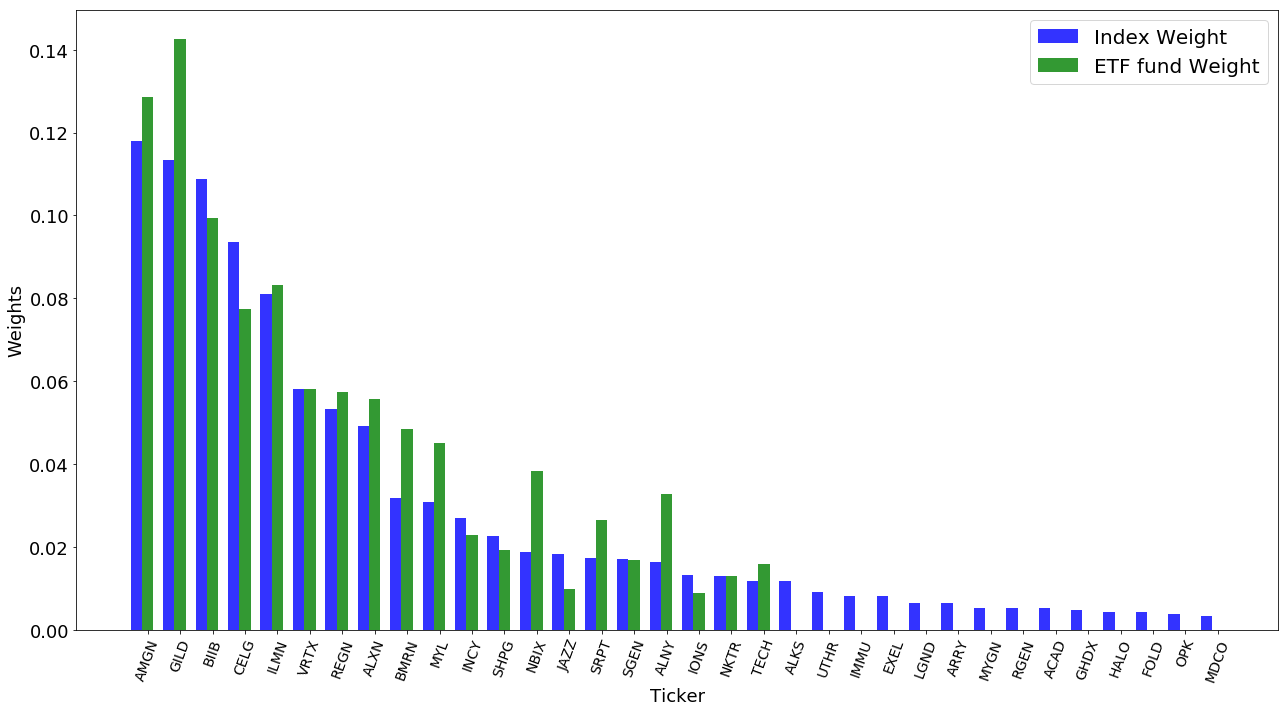

In [14]:
#  Plot bars of weights

num_topwtstock_2include = 20 #bad with 13, 16, 17, 18, 19, 20, 21,
# only the top weight stocks + no shorting 
b1a_ = [(0.0,1.0) for i in range(num_topwtstock_2include)] 
# exclude bottom weighted stocks
b1b_ = [(0.0,0.0) for i in range(num_topwtstock_2include,num_stock)] 
b1_ = b1a_ + b1b_ # combining the constraints
#b1_[num_topwtstock_2include:-1] = (0.0,0.0)
c1_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })  # Sum of active weights = 100%
# Calling the optimizer
wts_min_trackingerror2 = opt_min_te(TickerNWeights2, cov_end_annual, b1_, c1_)
# calc TE achieved
wts_active2 = wts_min_trackingerror2 - TickerNWeights2
TE_optimized2 = tracking_error(wts_active2,cov_end)

# ---  create plot of weights fund vs benchmark
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
fig, ax = plt.subplots(figsize=(18,10))
index = np.arange(len(TickerNWeights2))
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, TickerNWeights2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Index Weight')
 
rects2 = plt.bar(index + bar_width, wts_min_trackingerror2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='ETF fund Weight')
 
plt.xlabel('Ticker', fontsize=18)
plt.ylabel('Weights', fontsize=18)
plt.xticks(index + bar_width, (daily_close_px2.columns.values), fontsize=10, rotation=70)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=18)
plt.legend(fontsize=20)
 
plt.tight_layout()
plt.show()